# HW 6

In [1]:
#mydir = '/home/jkinser/Documents/courses/CDSCardinal/Version5/'
#mydir = '/Users/jkinser/Documents/CoursesKinser/CDSCardinal/Version5/'
mydir = '/Users/eric/Documents/CDS465/'

pysrc = mydir + 'pysrc/'
datadir = mydir + 'data/'
popdir = mydir + 'population/'

import sys
sys.path.append( pysrc )

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlite3 as sql

In [2]:
import Main
E = Main.Realm( datadir )
E.ReadAll(popdir + 'pop3_6.db')
#E.ReadAll( popdir + 'mpop10.db')
len(E.persondf)

82525

# Task 1
Are DNA stats drifting in time?

Explanation: You started with statistical distributions of each allele in the STR profile. The early population was created from these stats. However, your island has evolved in time. It is possible that these stats have drifted away from the original distribution.

Below is a script that will get the STR distribution for one locuse (TPOX) for one ethnic group (e0). This is the original distribution. The task is to gather data from four different time periods and create the same type of plot from actual data. You do _not_ have to use TPOX. Use any locus, but use ethnic group e0 as they will have the largest population.

Task:
1. For the centuries starting with the months (1000, 3000, 5000, 7000 )
    1. Get all citizens born in each century who have e0>0.9.
    1. Get their allele distribution for your chosen locus. 
1. Plot the distributions for these four sample periods on the same graph. You MUST tell me which color/marker is the first century, the second century, etc.
1. Draw your conclusion: Is the distribution for this one allele (one ethnic group) drifting in time?

In [3]:
from collections import Counter

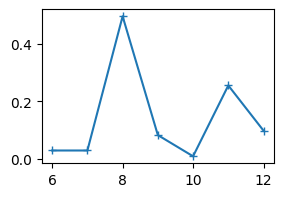

In [4]:
# code for students
# this is the order of the loci for STR
loci = ['D8S1179','D21S11','D7S820','CSF1PO','D3S1358','TH01',\
            'D13S317','D16S539','D2S1338','D19S433','VWA','TPOX',\
            'D18S51','D5S818','FGA']
locus = 'TPOX' # chosen by user
conn = sql.connect( datadir + 'dnastats.db') 
origdf = pd.read_sql( 'SELECT * FROM Data0TPOX', conn)
plt.figure( figsize=(3,2))
plt.plot( origdf['allele'], origdf['prob'], marker='+')

In [5]:
e0_df = E.persondf[['pid', 'birth','dometh', 'e0', 'nstr']].copy()

#add century col to use groupby
e0_df['century'] = np.where((1000 < e0_df['birth']) & (e0_df['birth'] < 1000+100*12), 
                            'cent1', 
                            np.where((3000 < e0_df['birth']) & (e0_df['birth'] < 3000+100*12),
                                     'cent2',
                                     np.where((5000 < e0_df['birth']) & (e0_df['birth'] < 5000+100*12),
                                              'cent3',
                                              np.where((7000 < e0_df['birth']) & (e0_df['birth'] < 7000+100*12),
                                                  'cent4',
                                                  np.where((0 < e0_df['birth']) & (e0_df['birth'] < 0+100*12),
                                                           'cent0',
                                                           ''
                                                      
                                                  )
                                              )
                                         
                                     )

                                )
                            )

#filter so only people that are born within one of the centuries we are interested in are selected and are > 0.9 e0
s1 = E.persondf['e0'] > 0.9 #mostly e0
s2 = e0_df['century'] != '' #is born in a century we are interested in
e0_df = e0_df.loc[s1 & s2]

ndx = loci.index(locus) #index pos of locus 
e0_df[locus] = (e0_df['nstr'].str.split(pat = ';', expand = True)[ndx].str.replace('[()]', '', regex=True).str.split(',')) #get alleles for locus


#get proportions in respect to the century
xploded_e0 = e0_df[['century', locus]].explode(locus).rename(columns={locus: 'allele'})
xploded_e0['allele'] = xploded_e0['allele'].astype(float).astype(int) # fix dtype; python sees str(8) and dynamically types the exploded it for float(8.0) when exploding a column
allele_cnts = xploded_e0.groupby('century')['allele'].value_counts() 
allele_prop = allele_cnts / allele_cnts.groupby(level=0).sum() #count / total by century

proportions_df = allele_prop.rename('proportion').to_frame().reset_index() #back to df for easier ploting

In [6]:
import seaborn as sns

"""#plot grouped plot of all bar charts individually
plt.figure(figsize=(6, 12))
g = sns.catplot(
    data=proportions_df,
    x='allele',
    y='proportion',
    col='century',        
    kind='bar',          
    col_wrap=2,       
    height=4,     
    aspect=1.2,
    order=sorted([int(val) for val in proportions_df['allele'].unique()])
)
g.fig.suptitle('Allele Frequency Distribution by Century', fontsize=16, y=1.02)
g.set_axis_labels('Allele (TPOX)', 'Proportion (Frequency)') #assign lable titles
g.set_titles('Century {col_name}')
plt.tight_layout()
plt.show()"""

"#plot grouped plot of all bar charts individually\nplt.figure(figsize=(6, 12))\ng = sns.catplot(\n    data=proportions_df,\n    x='allele',\n    y='proportion',\n    col='century',        \n    kind='bar',          \n    col_wrap=2,       \n    height=4,     \n    aspect=1.2,\n    order=sorted([int(val) for val in proportions_df['allele'].unique()])\n)\ng.fig.suptitle('Allele Frequency Distribution by Century', fontsize=16, y=1.02)\ng.set_axis_labels('Allele (TPOX)', 'Proportion (Frequency)') #assign lable titles\ng.set_titles('Century {col_name}')\nplt.tight_layout()\nplt.show()"

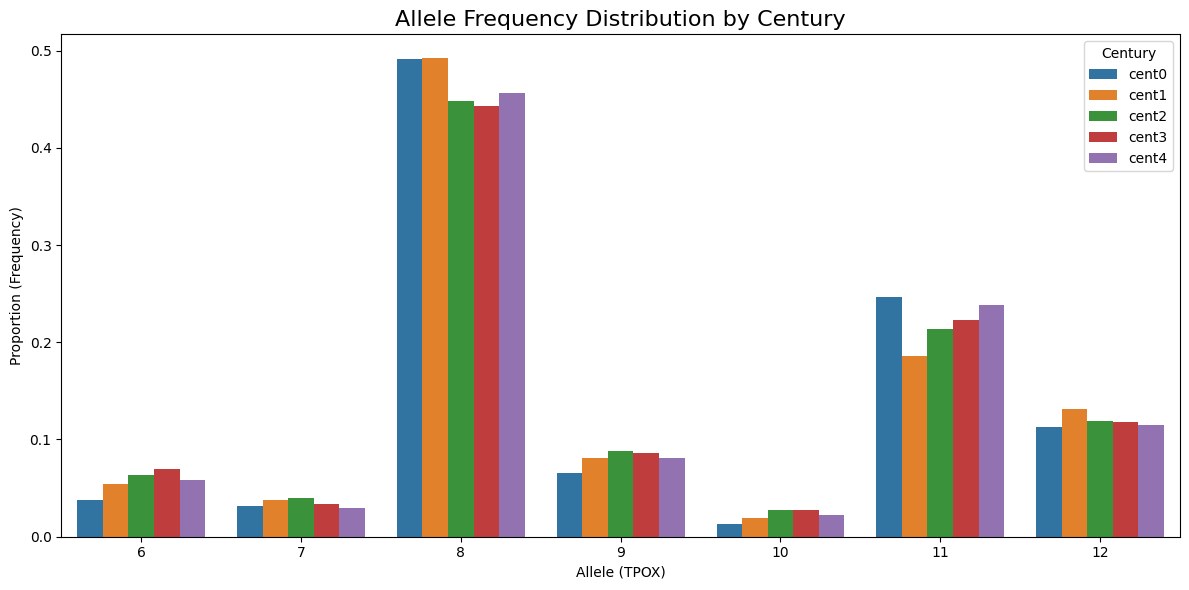

In [7]:
#ploting barcharts on one plot
plt.figure(figsize=(12, 6))
ax = sns.barplot(
    data=proportions_df,
    x='allele',
    y='proportion',
    hue='century',  
    order=sorted([int(val) for val in proportions_df['allele'].unique()])
)
plt.title('Allele Frequency Distribution by Century', fontsize=16) 
ax.set_xlabel(f'Allele ({locus})') #axis labels
ax.set_ylabel('Proportion (Frequency)')
ax.legend(title='Century') #add legend and label
plt.tight_layout()

plt.show()

In [8]:
proportions_wide = proportions_df.pivot(index='allele', columns='century', values='proportion')
proportions_wide

century,cent0,cent1,cent2,cent3,cent4
allele,,,,,
6,0.038,0.053903,0.063017,0.070082,0.058285
7,0.032,0.037452,0.039779,0.033602,0.029544
8,0.491,0.492125,0.448220,0.442795,0.456616
9,0.066,0.080504,0.088457,0.086020,0.080873
10,0.013,0.019076,0.027958,0.027118,0.022022
11,0.247,0.185859,0.213188,0.222609,0.237975
12,0.113,0.131082,0.119382,0.117774,0.114685


In my population, there seems to be some drift in allele 6 and 9, where those tended to increase as time increased. However, it was not a linear increase and is stochastic, meaning there is some randomness, it may be due to a deviation from the mean, but it appears it is not to the degree of many z scores away from the mean, leading me to believe at this point, there is not evidence to support the notion of evolution in this population

# Task 2
Moms should not birth babies less than 9 months apart - except for twins.

This simulation will create identical twins (same bio parents, birth data, and DNA). They will have consecutive _pid_ values.

Show that your population does not have any woman giving birth to babies less than 9 months apart - excepting twins.

In [9]:
# your code with explanation of what the output means.

s1 = E.hospdf['mom'] > 0 
mums = E.hospdf.loc[s1][['pid','mom','birthdate']]

mums = mums.sort_values(['mom', 'birthdate']).copy()
mums['months_between'] = mums.groupby('mom')['birthdate'].diff() #get months between births
mums['twin'] = mums.duplicated(subset=['mom', 'birthdate'], keep=False) #get twin flag


#prove no woman can give birth to babies in less than 9 months excluding twins
s1 = mums['months_between'] < 9 #try to find time between births occuring in less than 9 months
s2 = mums['twin'] == False #exclude twins

mums.loc[s1 & s2]


,pid,mom,birthdate,months_between,twin
index,,,,,


There are no results for births of babies in a less than 9 month window when excluding twins.

# Task 3
Consider a case in which we create 10 cell phone towers at random locations (even in the ocean). A citizen has a cell phone and needs to find the two closest towers.

Generate 10 random locations for your towers.

Create a DF which has the following columns
* pid : restrict to living citizens at least 13 years old.
* locv, loch: Their locations
* tower0, tower1, ... tower9: The distance from each citizen to this tower.
* T1: The name of the tower that is the closest to this each citizen. (I used __idxmin__.)
* T2: The name of the tower that is the second closest to each citizen.

In [ ]:
# Your code plus a display of the random rows of the DF

#generate 10 random cell towers 

def gen_towers(tower_names):
    """
    Generates n random cell towers based on a random number within the map;
        does not consider if a tower is generated in the ocean or on land.

    inpts: 
        tower_names (list): The names of the n number of cell towers
    opts:
        tower_dict (dict): A dictionary of the towers names as keys and 
            a list as the values with this formating [locv, loch] 
    """

    n = len(tower_names)
    a_n_2 = (np.random.uniform(0,1,size=(n,2))*2048).astype(int)

    tower_dict = dict()

    for i in range(len(tower_names)):
        if (a_n_2- a_n_2[i]).any() == 0:
            print('error, duplicate location was generated, run again') #add a try + except later
        else:
            tower_dict[tower_names[i]] = a_n_2[i]
    
    return tower_dict

def get_tower_distance(realmc):
    """
    Assigns the T1 and T2, the closest and second closest towers to ea person

    inpts:
        realmc (Realm): get persondf from Realm class
    opts:
        none
    """

    tower_dict = gen_towers(['tower'+str(x) for x in range(9+1)])

    #get data; query so only living people, age 13+ are included in the people and cell tower proximity df
    keep = ['pid','locv', 'loch']
    s1 = E.persondf['death'] < 0
    s2 = (E.month - E.persondf['birth'].values) > 12 * 13
    ct_df = E.persondf.loc[s1 & s2][keep]

    pp_locations = ct_df[['locv','loch']].values # bundle locv and loch
    towersvh = np.array(list(tower_dict.values())) #get tower locations in to a 10,2 matrix

    diffs = pp_locations[:,np.newaxis,:] - towersvh  #reshape to a n, 10, 2 matrix for broadcasting
    distances = np.linalg.norm(diffs, axis=2) #calc distances

    column_names = [name for name in tower_dict.keys()]
    df_distances = pd.DataFrame(distances, columns=column_names, index=ct_df.index) #np.array to pd.DataFrame obj
    ct_df = pd.concat([ct_df, df_distances], axis=1) #add distances to the ct_df

    sorted_indices = np.argsort(df_distances.values, axis=1) #get indicies rowise of closest towers in terms of distance
    index_to_name_map = dict(enumerate(column_names)) #indicies mapped back to tower names

    ct_df['T1'] = pd.Series(sorted_indices[:, 0]).map(index_to_name_map).to_list() #first closest
    ct_df['T2'] = pd.Series(sorted_indices[:, 1]).map(index_to_name_map).to_list() # second closest

    return ct_df



In [32]:
towers_df = get_tower_distance(E)

towers_df.head(5)

[[[ -486.87619996  -927.70117224]
  [ -681.87619996  -626.70117224]
  [-1105.87619996   698.29882776]
  ...
  [-1083.87619996 -1233.70117224]
  [  355.12380004    44.29882776]
  [ -962.87619996 -1033.70117224]]

 [[ -472.18599042  -890.86825779]
  [ -667.18599042  -589.86825779]
  [-1091.18599042   735.13174221]
  ...
  [-1069.18599042 -1196.86825779]
  [  369.81400958    81.13174221]
  [ -948.18599042  -996.86825779]]

 [[  417.22619725  -930.95656615]
  [  222.22619725  -629.95656615]
  [ -201.77380275   695.04343385]
  ...
  [ -179.77380275 -1236.95656615]
  [ 1259.22619725    41.04343385]
  [  -58.77380275 -1036.95656615]]

 ...

 [[  239.42565369  -313.74261743]
  [   44.42565369   -12.74261743]
  [ -379.57434631  1312.25738257]
  ...
  [ -357.57434631  -619.74261743]
  [ 1081.42565369   658.25738257]
  [ -236.57434631  -419.74261743]]

 [[  286.5049964   -236.95721524]
  [   91.5049964     64.04278476]
  [ -332.4950036   1389.04278476]
  ...
  [ -310.4950036   -542.95721524]
  [ 

,pid,locv,loch,tower0,tower1,tower2,tower3,tower4,tower5,tower6,tower7,tower8,tower9,T1,T2
index,,,,,,,,,,,,,,,
61143,61144,497.123800,752.298828,1047.701245,926.126077,1307.892741,1178.282434,1683.930754,218.869185,421.172372,1642.195542,357.876095,1412.681383,tower5,tower8
61238,61239,511.814010,789.131742,1008.268745,890.551350,1315.714841,1176.330250,1649.268313,210.548388,434.872492,1604.883893,378.608982,1375.791771,tower5,tower8
61592,61593,1401.226197,749.043434,1020.175391,668.004310,723.738933,420.264388,1145.154127,1083.434666,1324.636236,1249.952066,1259.894908,1038.620855,tower3,tower1
61669,61670,1662.566690,1259.574137,798.254758,498.095654,1207.044817,871.714126,579.983623,1385.757347,1655.928375,730.990875,1617.515714,564.054477,tower1,tower9
61745,61746,1207.251526,1404.816990,354.354248,38.270951,1407.594897,1095.718242,722.730352,1019.744714,1290.491966,690.985972,1272.915838,457.364492,tower1,tower0


In [28]:
E.isle['raw'][:,:,0].min()

np.float64(0.0)